## Прогнозирование заболеваемости COVID
Для решения данной задачи будет проведено обучение рекурентной LSTM нейронной сети. Данная архитектура сети лучше всего позволяет прогнозировать временные ряды.
В качестве тестовых и трейновых данных будет использоваться датасет о заболеваемости короновирусом в России - [COVID.csv](https://github.com/Koldim2001/time_series_theory/blob/main/COVID.csv)

In [546]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import math
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import datetime

Будем рассматривать данные по числу заражений в день

In [547]:
df = pd.read_csv('COVID.csv')
columns = df.columns
print("Всего дней в датасете", len(df))
df.head()

Всего дней в датасете 976


,DateTime,Заражений за день,Выздоровлений за день,Смертей за день
0,2020-03-12 00:00:00,34,0,0
1,2020-03-13 00:00:00,11,0,0
2,2020-03-14 00:00:00,14,0,0
3,2020-03-15 00:00:00,4,3,0
4,2020-03-16 00:00:00,28,2,0


In [548]:
max_time = datetime.datetime(2022, 1, 1, 0, 0)

In [549]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.query("DateTime < @max_time")
df['DateTime'].min()

Timestamp('2020-03-12 00:00:00')

Обрежем данные по конец 2021 года. Будем предсказывать именно поведение заболеваемости в конце того года по результатм исследования заболеваемости начиная с марта 2020 года. То есть предсказание будет осуществляться благодаря данным о заболеваемости за последние чуть больше чем полтора года 

In [550]:
df['DateTime'].max()

Timestamp('2021-12-31 00:00:00')

In [551]:
df.index = pd.to_datetime(df.DateTime)
df = df['Заражений за день'].to_frame()
df.head()

,Заражений за день
DateTime,
2020-03-12,34
2020-03-13,11
2020-03-14,14
2020-03-15,4
2020-03-16,28


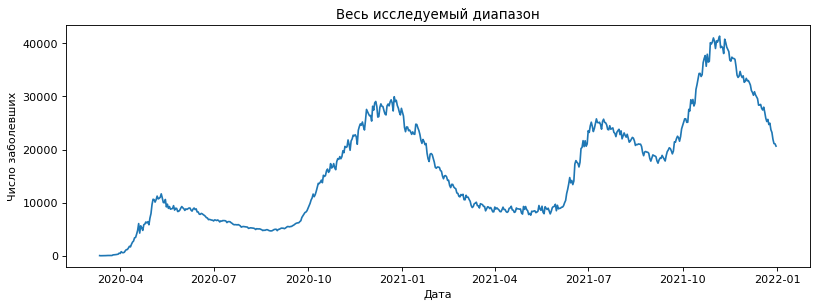

In [552]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.index,df['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('Весь исследуемый диапазон')
plt.show()

Отрежем последние 100 дней от исходного датафрейма. Будем последние 100 дней ипользовать как тест нашего предсказания. <br>
Данное число дней взято таким образом, чтобы пресказать на тесте поведение новой волны - послдней волны 2021 года, которая началась в сентябре

In [553]:
x = df.shape[0] - 100
print('Число дней, на которых будем обучать =', x)

Число дней, на которых будем обучать = 560


Обрежем данные на тест и трейн:

In [554]:
dataset = df.values.astype('float32') 
train = df.iloc[:x]
test = df.iloc[x:]

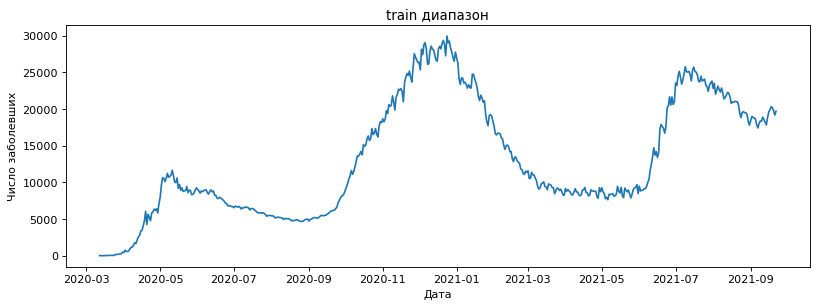

In [555]:
figure(figsize=(12, 4), dpi=80)
plt.plot(train.index, train['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('train диапазон')
plt.show()

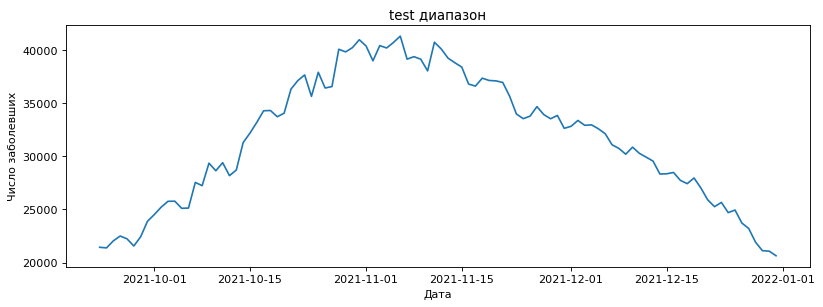

In [556]:
figure(figsize=(12, 4), dpi=80)
plt.plot(test.index, test['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('test диапазон')
plt.show()

Теперь сделаем нормализацию данных, которые будут использоваться при обучении и тестировании работы нейронной сети. Воспользуемся для этого MinMaxScaler и сделаем его fit на трейновых данных

In [557]:
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

Напишем функцию для предподготовки данных для обучения и тестирования работы рекурентной сети.<br>
На вход подаются значения за _seq_size_ дней предыдущих и на выходе сеть предсказывает последующее одно значение. Тем самым архитектура сети является Sequence-to-vector 

In [558]:
seq_size = 20

Благодаря проведенным испытаниям работы сети лучшим гиперпараметром стало число шагов назад для анализа равное 20. <br>
То есть сеть при предсказании последующего значения обладает информацией о последних 20 значениях заболеваемости. На вход LSTM сети будет поступать на каждом шаге именно 20 значений.

In [559]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [560]:
trainX, trainY = to_sequences(train_scaled, seq_size)
testX, testY = to_sequences(test_scaled, seq_size)

In [561]:
print("Размер данных для обучения (train): {}".format(trainX.shape))
print("Размер данных для теста (test): {}".format(testX.shape))

Размер данных для обучения (train): (539, 20)
Размер данных для теста (test): (79, 20)


При этом оценивать качество сети мы будем не только как умение с высокой точностью пресказывать 21-ое значение при задании 20 известных значений, но и сам факт пресказания, в котором каждое последующее пресказание имеет накопительную ошибку предыдущих предсказаний.
<br>То есть при тестировании будет использоваться не только test датасет, который мы на прошлом шаге составили, но и датасет который будет составляться сам в процессе пресказания. В таком случае мы по предсказвнным значениям будем предсказывать следующие значения и так далее.

Для подачи данных на обучение надо немного решейпнуть данные, приведя их к виду: trainX.shape[0], число фич, trainX.shape[1].<br>
Число фич - это по сути число различных временных одновременных последовательностей, принимающих участие в предсказании. <br>В нашем случае мы предсказывем поведение временной зависимости заболеваемости от ее же поведения за предыдущие моменты времени, поэтому число фич = 1

In [562]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [563]:
print("Финальный размер данных для обучения (train): {}".format(trainX.shape))
print("Финальный размер данных для теста (test): {}".format(testX.shape))

Финальный размер данных для обучения (train): (539, 1, 20)
Финальный размер данных для теста (test): (79, 1, 20)


__Зададим модель нейронной сети:__

In [564]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(None, seq_size)))  # Первый слой LSTM
# return_sequences=True так LSTM первого слоя передает данные на второй слой LSTM
model.add(LSTM(64, activation='relu'))  # Второй слой LSTM
model.add(Dense(64))  # Полносвязный слой из 64 нейронов
model.add(Dense(1))  # Выходной слой (одно значение на выходе сети)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, None, 150)         102600    
                                                                 
 lstm_33 (LSTM)              (None, 64)                55040     
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 161,865
Trainable params: 161,865
Non-trainable params: 0
_________________________________________________________________


__Обучение сети:__

In [565]:
print('Train...')
history = model.fit(x=trainX,
                    y=trainY,        
                    validation_data=(testX, testY), 
                    epochs=50)

Train...
Epoch 1/50
17/17 [==============================] - 2s 20ms/step - loss: 0.1273 - val_loss: 0.0231
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0196 - val_loss: 0.0934
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0129 - val_loss: 0.0389
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0538
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0409
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0484
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0430
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0487
Epoch 9/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0340
Epoch 10/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0162
Epoch 11/

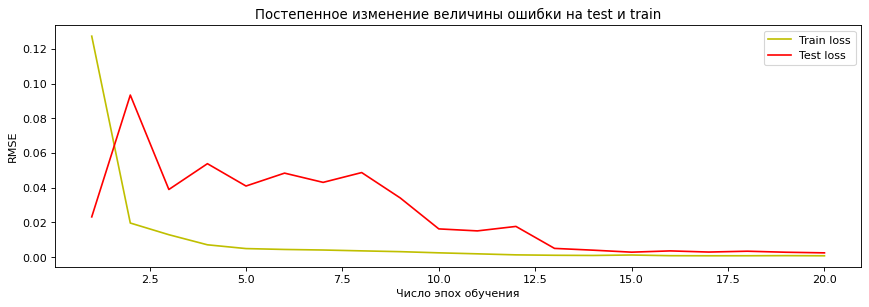

In [566]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
figure(figsize=(13, 4), dpi=80)
plt.plot(epochs[:20], loss[:20], 'y', label='Train loss')
plt.plot(epochs[:20], val_loss[:20], 'r', label='Test loss')
plt.title('Постепенное изменение величины ошибки на test и train')
plt.xlabel('Число эпох обучения')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [567]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


3/3 [==============================] - 0s 2ms/step


Вычисление root mean squared error:

In [568]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 661.80 RMSE
Test Score: 1051.68 RMSE


Подготовка данных к отображению на графиках:

Мы должны сместить прогнозы так, чтобы они совпали по оси x с исходным набором данных.

In [569]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

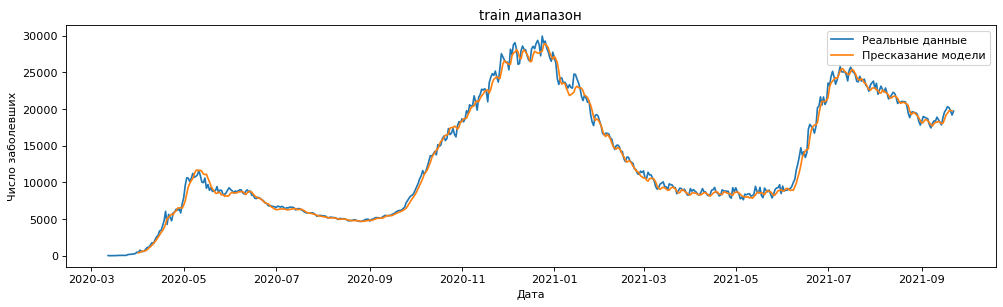

In [570]:
figure(figsize=(15, 4), dpi=80)
plt.plot(train.index, train['Заражений за день'], label='Реальные данные')
plt.plot(train.index, trainPredictPlot[:560], label='Пресказание модели')
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('train диапазон')
plt.legend()
plt.show()

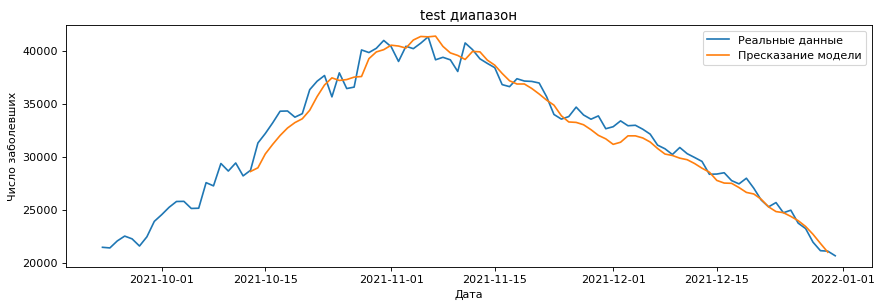

In [571]:
figure(figsize=(13, 4), dpi=80)
plt.plot(test.index, test['Заражений за день'], label='Реальные данные')
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.plot(test.index, testPredictPlot[-100:], label='Пресказание модели')
plt.title('test диапазон')
plt.legend()
plt.show()